# Initial configuration

In [6]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl")
from travel import init_travel
init_travel()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import json

VQG2VQA_RESULTS_PATH = "/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_debug250/llava-1.5-7b-hf/VQG2VQA_ego4d_debug250_llava-1.5-7b-hf_20240701115231/preds_heuristic_val.json"
preds_vqg2vqa = json.load(open(VQG2VQA_RESULTS_PATH, "r"))

SPATIAL_RESULTS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_debug250/llava-1.5-7b-hf/VQG2VQA_ego4d_debug250_llava-1.5-7b-hf_spatial1.0_20240701115730/preds_heuristic_val.json"
preds_spatial = json.load(open(SPATIAL_RESULTS_PATH, "r"))

In [29]:
from travel.model.mistake_detection import calculate_abstention_metrics, plot_abstention_metrics, DETECTION_FRAMES_PROPORTION

def get_frame_times(pred):
    frame_times = pred['example']['frame_times']
    cutoff_time = get_cutoff_time_by_proportion(frame_times, DETECTION_FRAMES_PROPORTION)
    frame_times = [t for t in frame_times if t >= cutoff_time]
    return frame_times

def plot_abstention_curve(all_probs, all_labels, result_name, save_path):
    penalty = 1
    thresholds = np.linspace(0.0, 1.0, 101) # [0.0, 0.01, 0.02, 0.03, ..., 0.98, 0.99, 1.0]
    thresholds = [t for t in thresholds if t >= 0.5] # [0.50, 0.51, ..., 0.98, 0.99, 1.0] (only keep thresholds at least 0.5 because every class is predicted with at least 0.5 likelihood in binary classification)

    coverages, risks, eff_reliabilities, sp_recalls = [], [], [], []
    for t in tqdm(thresholds, desc="thresholds"):
        c, r, e, spr, _ = calculate_abstention_metrics(all_probs, [1 if l else 0 for l in all_labels], t, penalty)
        coverages.append(c)
        risks.append(r)
        eff_reliabilities.append(e)
        sp_recalls.append(spr)     
                   
    plot_abstention_metrics(thresholds, coverages, risks, eff_reliabilities, sp_recalls, result_name, [save_path])
                   
    return coverages, risks, eff_reliabilities, sp_recalls

def convert_mistake_prob_to_confidence(p):
    return abs(p - (1-p))

500it [00:00, 9569.96it/s]
thresholds: 100%|██████████| 51/51 [00:00<00:00, 3127.88it/s]


([1.0,
  1.0,
  1.0,
  0.996,
  0.99,
  0.988,
  0.982,
  0.974,
  0.972,
  0.972,
  0.97,
  0.958,
  0.948,
  0.94,
  0.924,
  0.918,
  0.908,
  0.902,
  0.892,
  0.886,
  0.872,
  0.856,
  0.848,
  0.83,
  0.816,
  0.798,
  0.786,
  0.768,
  0.746,
  0.732,
  0.698,
  0.674,
  0.654,
  0.632,
  0.6,
  0.574,
  0.55,
  0.532,
  0.512,
  0.488,
  0.456,
  0.428,
  0.404,
  0.376,
  0.348,
  0.328,
  0.292,
  0.278,
  0.246,
  0.222,
  0.178],
 [0.358,
  0.358,
  0.358,
  0.357429718875502,
  0.35555555555555557,
  0.354251012145749,
  0.3564154786150713,
  0.35728952772073924,
  0.3559670781893004,
  0.3559670781893004,
  0.35670103092783506,
  0.3569937369519833,
  0.35864978902953587,
  0.3553191489361702,
  0.3528138528138528,
  0.3485838779956427,
  0.3524229074889868,
  0.352549889135255,
  0.35201793721973096,
  0.35214446952595935,
  0.35091743119266056,
  0.352803738317757,
  0.3490566037735849,
  0.344578313253012,
  0.3431372549019608,
  0.3458646616541353,
  0.33587786259541

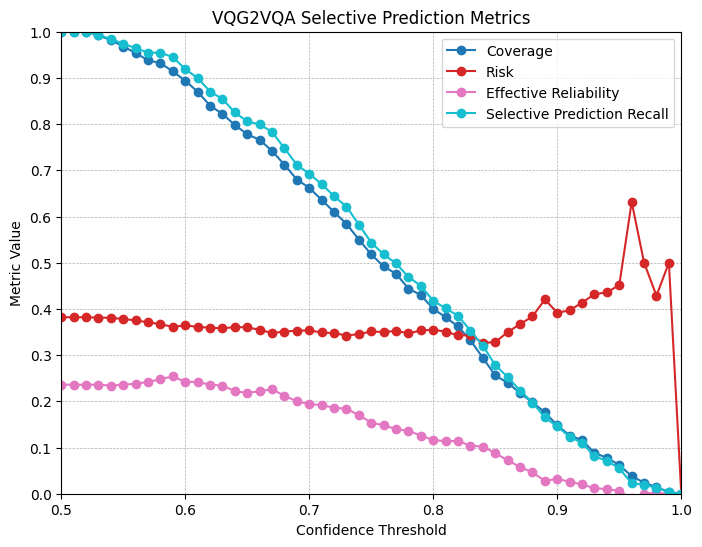

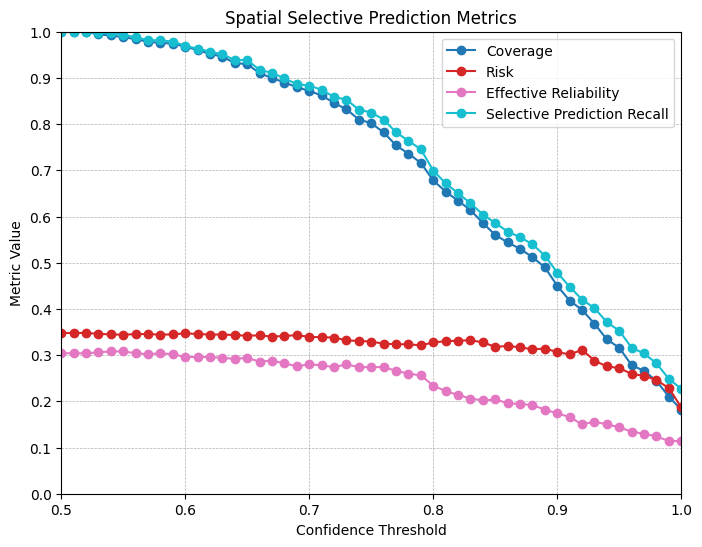

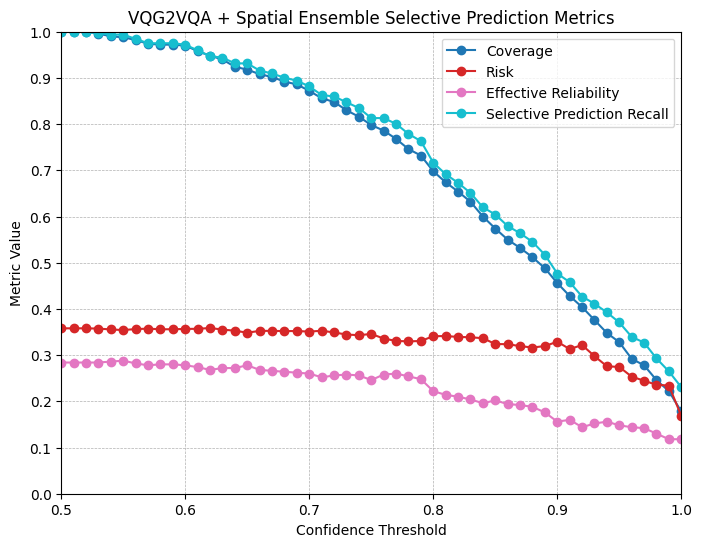

In [34]:
import datetime
import numpy as np
import os
from pprint import pprint
from tqdm import tqdm

from travel.constants import RESULTS_DIR
from travel.data.mistake_detection import get_cutoff_time_by_proportion
from travel.model.mistake_detection import aggregate_mistake_probs_over_frames    

all_mistake_probs_vqg2vqa = []
all_mistake_probs_spatial = []
all_mistake_probs_combined = []
all_labels = []
for pred_idx, (pred_vqg2vqa, pred_spatial) in enumerate(tqdm(zip(preds_vqg2vqa.values(), preds_spatial.values()))):
    assert pred_vqg2vqa['example']['example_id'] == pred_spatial['example']['example_id']
    frame_times = get_frame_times(pred_vqg2vqa)
            
    mistake_probs_vqg2vqa = pred_vqg2vqa['mistake_detection']["0.0"]['mistake_probs']
    mistake_probs_spatial = pred_spatial['mistake_detection']["0.0"]['mistake_probs']

    # Combine mistake probabilities based on confidence
    mistake_probs_combined = [[sorted([mpv_q, mps_q], reverse=True, key=lambda x: convert_mistake_prob_to_confidence(x))[0] for mpv_q, mps_q in zip(mpv, mps)] for mpv, mps in zip(mistake_probs_vqg2vqa, mistake_probs_spatial)]
    
    # Or combine based on max mistake probability
    # mistake_probs_combined = [[max(mpv_q, mps_q) for mpv_q, mps_q in zip(mpv, mps)] for mpv, mps in zip(mistake_probs_vqg2vqa, mistake_probs_spatial)]
    
    # Aggregate across frames for separate and combined 
    mistake_prob_vqg2vqa =  aggregate_mistake_probs_over_frames(mistake_probs_vqg2vqa, frame_times)              
    mistake_prob_spatial =  aggregate_mistake_probs_over_frames(mistake_probs_spatial, frame_times)              
    mistake_prob_combined = aggregate_mistake_probs_over_frames(mistake_probs_combined, frame_times)
    
    all_mistake_probs_vqg2vqa.append(mistake_prob_vqg2vqa)
    all_mistake_probs_spatial.append(mistake_prob_spatial)
    all_mistake_probs_combined.append(mistake_prob_combined)                
    
    all_labels.append(1 if pred_vqg2vqa['example']['mistake'] else 0)
             
timestamp = datetime.datetime.now()
results_dir = os.path.join(RESULTS_DIR, "analysis", f"ensemble_vqg2vqa_spatial_{timestamp.strftime('%Y%m%d%H%M%S')}")
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

plot_abstention_curve(all_mistake_probs_vqg2vqa, all_labels, "VQG2VQA", os.path.join(results_dir, "abstention_vqg2vqa.pdf"))
plot_abstention_curve(all_mistake_probs_spatial, all_labels, "Spatial", os.path.join(results_dir, "abstention_spatial.pdf"))
plot_abstention_curve(all_mistake_probs_combined, all_labels, "VQG2VQA + Spatial Ensemble", os.path.join(results_dir, "abstention_combined.pdf"))